<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202302/blob/main/Lecture04/Notebook_SS04_Ridge.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Regularization

## Predicting Wages

Our objective today is to construct a model of individual wages

$$
w = f(X) + u 
$$

where w is the  wage, and X is a matrix that includes potential explanatory variables/predictors. In this tutorial set, we will focus on a linear model of the form

\begin{align}
 ln(w) & = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p  + u 
\end{align}

were $ln(w)$ is the logarithm of the wage.

To illustrate I'm going to use a sample of the NLSY97. The NLSY97 is  a nationally representative sample of 8,984 men and women born during the years 1980 through 1984 and living in the United States at the time of the initial survey in 1997.  Participants were ages 12 to 16 as of December 31, 1996.  Interviews were conducted annually from 1997 to 2011 and biennially since then.  

Let's load the packages and the data set:

In [1]:
#install.packages("pacman") #for google colab

In [2]:
#packages
require("pacman")
p_load("tidyverse","stargazer")

nlsy <- read_csv('https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/nlsy97.csv')

nlsy <- nlsy  %>%   drop_na(educ) #drops NAs

Loading required package: pacman

Rows: 1266 Columns: 994
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (994): lnw_2016, educ, black, hispanic, other, exp, afqt, mom_educ, dad_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We want to construct a model that predicts well out of sample, and we have potentially 994 regressors. We are going to regularize this regression using the `glmnet` package.


## Glmnet

To apply a regularized model, we can use the `glmnet::glmnet()` function. `glmnet` solves the problem

$$
\min_{\beta_0,\beta} \frac{1}{N} \sum_{i=1}^{N} w_i l(y_i,\beta_0+\beta' x_i) + \lambda\left[(1-\alpha)\frac{1}{2}\|\beta\|_2^2 + \alpha \|\beta\|_1\right],
$$

where $l(y_i,\beta_0+\beta^T x_i)$ in the regression case is $\frac{1}{2}(y_i-\beta_0-\beta' x_i)$

The `alpha` parameter tells `glmnet` to perform a ridge (`alpha` = 0), lasso (`alpha` = 1), or elastic net (0 < `alpha` < 1) model. 

By default, `glmnet` will do two things that you should know:

1.  By default, `glmnet` automatically standardizes your features. If you standardize your predictors prior to glmnet you can turn this argument off with `standardize = FALSE`.

2. The regularization path is computed at a grid of values (on the log scale) for the regularization parameter $\lambda$. The algorithm is extremely fast!

`glmnet` has some drawbacks, the main one is that we need to specify the arguments in terms of matrices and vectors

`caret`, in contrast, streamlines the process of creating predictive models by providing a uniform interface for predictive models, which, among other things, allows for specifying formulas.

## Ridge

We first illustrate ridge regression, which can be fit using `glmnet()` with alpha = 0 and seeks to minimize

$$
\frac{1}{2n}\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}    \right) ^ 2 + \lambda \frac{1}{2}\sum_{j=1}^{p} \beta_j^2 .
$$

Notice that the intercept is not penalized. Why?


Ridge penalizes the squares  of the coefficients. As a result, ridge shrinks coefficients toward zero, but not all the way.


To understand the mechanics, we are going to focus on a small subset of variables:

1. **educ (Education Level)**  
   - This typically refers to the respondent's **highest level of education completed**.  
   - It is measured in **years of schooling** 
 
2. **mom_educ (Mother’s Education Level)**

- This represents the highest level of education completed by the respondent’s mother.
- Like "educ," it can be measured in years of schooling 
  

In [3]:
p_load("glmnet")

#Vector that needs predicting
y <- nlsy$lnw_2016

# Matrix of predictors 
Xsmall <- as.matrix(nlsy  %>% select(educ,mom_educ))

Let's run the ridge regression (we need to set the parameter `alpha` to zero)

We solve:

$$
\min_{\beta_0,\beta_1,\beta_2} \frac{1}{N} \sum_{i=1}^{n} \left( log(wage)_i - \beta_0 -  \beta_1 Educ_i - \beta_2 MomEduc_i   \right) ^ 2 + \lambda \frac{1}{2} \left(\beta_1^2+ \beta_2^2 \right)
$$

In [4]:
ridge1 <- glmnet(
  x = Xsmall,
  y = y,
  lambda=1,
  alpha = 0 #ridge
)

In [5]:
coef(ridge1)

3 x 1 sparse Matrix of class "dgCMatrix"
                    s0
(Intercept) 2.38973488
educ        0.03286252
mom_educ    0.01877242

Are these shrunken relative to OLS?

In [6]:
stargazer(lm(y~Xsmall),type="text")


                        Dependent variable:    
                    ---------------------------
                                 y             
-----------------------------------------------
Xsmalleduc                   0.070***          
                              (0.009)          
                                               
Xsmallmom_educ                0.021**          
                              (0.011)          
                                               
Constant                     1.827***          
                              (0.149)          
                                               
-----------------------------------------------
Observations                   1,266           
R2                             0.069           
Adjusted R2                    0.068           
Residual Std. Error      0.839 (df = 1263)     
F Statistic          47.094*** (df = 2; 1263)  
Note:               *p<0.1; **p<0.05; ***p<0.01


H.W. Why the intercepts are not equal? Tip: Think on how the intercept is computed.

### Regularization Paths

Let's see the regularization path, that shows how much the coefficients are penalized for different values of $\lambda$. 

In [7]:
ridge2 <- glmnet(
  x = Xsmall,
  y = y,
  alpha = 0 #ridge
)

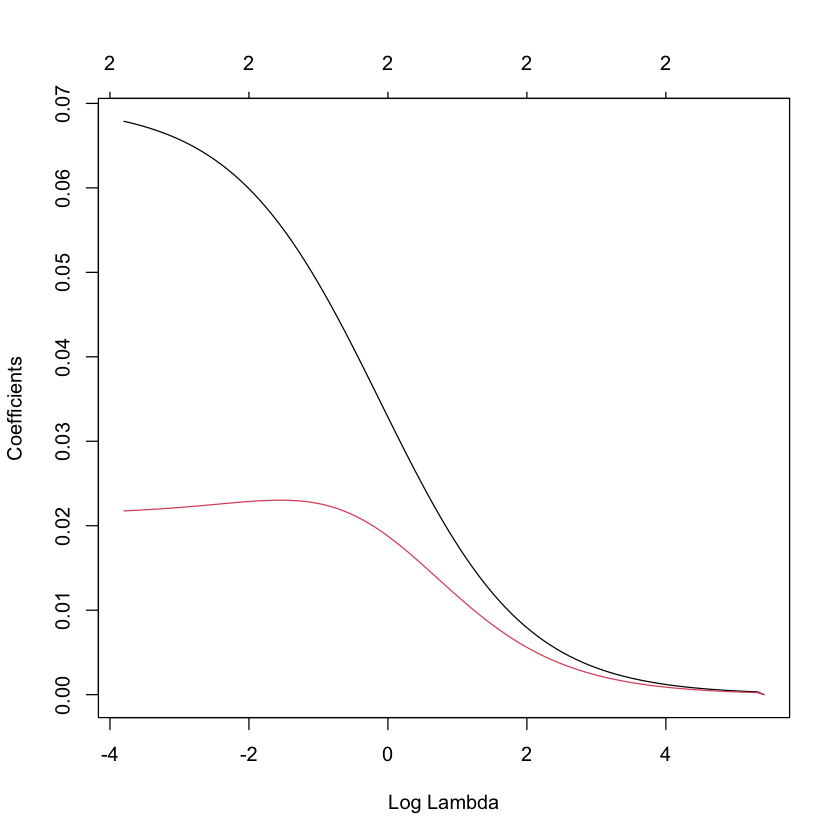

In [8]:
plot(ridge2, xvar = "lambda")

Notice none of the coefficients are forced to be zero, although they get close to it.

#### All the predictors

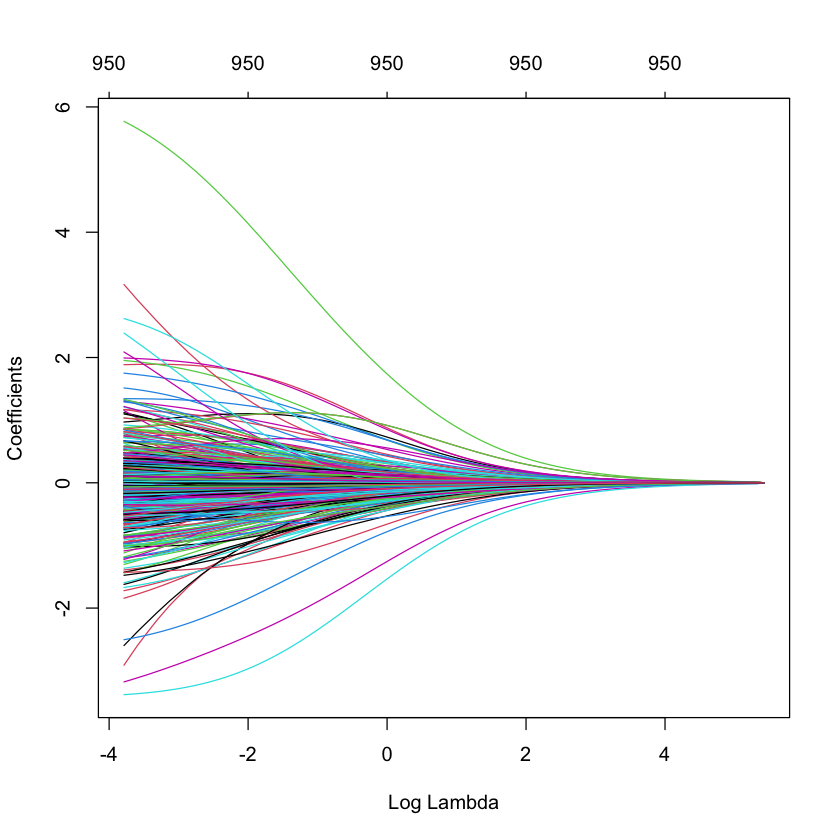

In [9]:
# Matrix of predictors (all but lnw_2016)
X <- as.matrix(nlsy  %>% select(-lnw_2016))

ridge_all <- glmnet(
  x = X,
  y = y,
  alpha = 0 #ridge
)

plot(ridge_all, xvar = "lambda")


The *regularization path*, which illustrates how the model’s coefficients change as we vary the regularization strength $\lambda$. Specifically:

1. **Penalizing Coefficients:**  
   When $\lambda$ is large, the penalty on the size of the coefficients is strong, pushing most coefficients toward zero (or shrinking them substantially). This helps prevent overfitting by limiting how large the coefficients are.

2. **Relaxing the Penalty:**  
   As $\lambda$ decreases, the penalty weakens. Coefficients that were previously shrunk toward zero may increase in magnitude if they improve the model’s fit to the data. Consequently, the model becomes more flexible and potentially more prone to overfitting.

3. **Visualizing the Path:**  
   We can plot each coefficient across a range of $\lambda$ values. Each line on the plot corresponds to a coefficient, showing how it changes from near-zero (with high $\lambda$) to larger values (with lower $\lambda$).

Overall, analyzing this path provides insight into the trade-off between regularization (controlling overfitting) and model complexity.

### Scale Equivariance

Since regularized methods apply a penalty to the coefficients, we need to ensure our coefficients are on a common scale. If not, then predictors with naturally larger values  will be penalized more than predictors with naturally smaller values.



Let's run the ridge regression (we need to set the parameter `alpha` to zero)

In [10]:
ridge <- glmnet(
  x = Xsmall,
  y = y,
  alpha = 0, #ridge
  lambda=20,
  standardize=FALSE,
)

Let's see the coefficients we obtained


In [11]:
coef(ridge)

3 x 1 sparse Matrix of class "dgCMatrix"
                     s0
(Intercept) 2.701109784
educ        0.019789865
mom_educ    0.009432237

Compare to OLS

In [12]:
ols<-lm(y~Xsmall)
stargazer(ols,type="text")


                        Dependent variable:    
                    ---------------------------
                                 y             
-----------------------------------------------
Xsmalleduc                   0.070***          
                              (0.009)          
                                               
Xsmallmom_educ                0.021**          
                              (0.011)          
                                               
Constant                     1.827***          
                              (0.149)          
                                               
-----------------------------------------------
Observations                   1,266           
R2                             0.069           
Adjusted R2                    0.068           
Residual Std. Error      0.839 (df = 1263)     
F Statistic          47.094*** (df = 2; 1263)  
Note:               *p<0.1; **p<0.05; ***p<0.01


#### What happens if we change the scale for mother's education?

In [13]:
Xsmall[,2]<-Xsmall[,2]/10 #divide by 10, put it in decades

In [14]:
ridge_10 <- glmnet(
  x = Xsmall,
  y = y,
  alpha = 0, #ridge
  lambda=20,
  standardize=FALSE,
)

In [15]:
coef(ridge_10)[3]

[1] 0.001165001

The original in years

In [16]:
coef(ridge)[3]

[1] 0.009432237

In [17]:
ols_10<-lm(y~Xsmall)
summary(ols_10)


Call:
lm(formula = y ~ Xsmall)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8546 -0.4003 -0.0458  0.3573  4.3549 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.827198   0.148795  12.280  < 2e-16 ***
Xsmalleduc     0.069777   0.008997   7.756  1.8e-14 ***
Xsmallmom_educ 0.213382   0.108671   1.964   0.0498 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8392 on 1263 degrees of freedom
Multiple R-squared:  0.0694,	Adjusted R-squared:  0.06793 
F-statistic: 47.09 on 2 and 1263 DF,  p-value: < 2.2e-16


In [18]:
ols_10$coefficients[3]/10

Xsmallmom_educ 
    0.02133815

In [19]:
ols$coefficients[3] #the original

Xsmallmom_educ 
    0.02133815

Does it work if we reescale the ridge coefficient?

In [20]:
coef(ridge_10)[3]/10

[1] 0.0001165001

#### A Bit of intuition

$$
\tilde{MomEduc}_i = \frac{MomEduc_i}{10}
$$

Now the model becomes:

$$
log(wage)_i = \beta_0 -  \beta_1 Educ_i - \tilde{\beta}_2 \tilde{MomEduc}_i + u_i
$$

where $\tilde{\beta}_2=10 \beta_2$

Substituting into the ridge penalty term:

$$
\lambda (\beta_1^2 + \beta_2^2) = \lambda \left( \beta_1^2 + \left(\frac{\tilde{\beta}_2}{10}\right)^2 \right)
$$

which simplifies to:

$$
\lambda \beta_1^2 + \lambda \frac{\tilde{\beta}_2^2}{100}
$$

This means that **the penalty on $\beta_2$ is scaled down by a factor of 100** when the variable is rescaled. In other words:

- **Before scaling**, the mother's education variable is shrunken at the same rate as years of education because they are on the same scale.
- **After scaling**, the shrinkage is relatively **smaller** because the coefficient is now divided by a factor.


Take aways:

1. **Magnitude Matters:**  
   - The ridge penalty **shrinks large coefficients more** because it treats all variables equally in regularization.
   - Thus, if mother's education is measured in years, its coefficient will be **larger** than if measured in decades, leading to a **stronger penalization**.

2. **Standardization Helps:**  
   - In practice, ridge regression often **standardizes variables** to avoid uneven penalization.
   - Standardizing ensures that all variables have a mean of 0 and variance of 1, making ridge penalties apply evenly. Variables now are unitless.



### Penalty selection

Now we need to discuss how we select $\lambda$: 

- Making sure that we have **zero bias** within the sample creates **out-of-sample problems**: **Bias-Variance trade-off**.

- We make this trade-off **empirically**.

    \begin{align}
            min_{\beta} E(\beta) = \sum_{i=1}^n (y_i-\beta_0 - x_{i1}\beta_1 - \dots - x_{ip}\beta_p)^2 + \lambda \sum_{j=1}^p R(\beta_j)
    \end{align}

- **$\lambda$ is the price for this trade-off**.

How do we choose  $\lambda$? -> $\rightarrow$  **Cross-validation**.


1. Initialization: Initially, we select a range of $\lambda$ values. These could be chosen based on prior knowledge, heuristics, or a predefined range.

2. Iteration Over Folds:

    - Fold 1 as Validation: We train the Ridge regression model on Folds 2-5 (combining them to form the training set) and validate the model on Fold 1. We record the MSE  for each $\lambda$  value.
    - Fold 2 as Validation: Next, we train on Folds 1, 3-5 and validate on Fold 2, recording the MSE  for each $\lambda$  value.
    - We repeat this process, training on four folds and validating on the remaining one, cycling through until each fold has served as the validation set.
  

<div>
<img src="../Modulo02/figs_notebook_SS03/fold.png" width="500"/>
</div>


- Error Aggregation: For each $\lambda$   value, we average the MSE across all five folds. 

- Selection of $\lambda$ : We select the $\lambda$  value that yields the lowest MSE. This is the value that we expect to generalize best to unseen data.

Let's do it on all the predictors:

In [21]:
#Vector that needs predicting
y <- nlsy$lnw_2016

# Matrix of predictors (all but lnw_2016)
X <- as.matrix(nlsy  %>% select(-lnw_2016))


#### 1. Initialization: Initially, we select a range of $\lambda$ values. 

In [22]:


# Define lambda sequence
lambda_seq <- 10^seq(4, -2, length = 100)



#### 2. Iteration Over Folds:

##### Create the folds

In [23]:
K <- 5  # 5-fold cross-validation

# Create folds
set.seed(123)  # Ensure reproducibility
folds <- sample(rep(1:K, length.out = length(y)))  # Assign randomly 1-5 to each observation.
folds 

[1] 5 3 4 1 5 3 2 3 3 5 2 4 1 5 3 3 2 5 1 4 1 2 3 5 3 4 2 4 5 5 2 2 3 1 4 4 1
  [38] 2 1 2 3 1 2 4 3 4 2 1 1 5 1 3 5 4 2 1 3 3 3 2 4 4 1 3 4 5 4 3 3 1 2 3 1 1
  [75] 1 4 2 3 5 2 4 4 5 5 3 1 5 5 1 2 2 1 4 1 3 3 2 2 5 4 2 1 1 2 5 5 1 4 1 4 5
 [112] 4 2 1 2 5 4 2 5 1 5 5 1 4 4 4 4 2 2 1 1 4 2 4 2 4 3 2 1 5 5 2 2 1 3 3 5 1
 [149] 5 2 3 5 5 5 1 3 1 3 4 5 5 3 2 2 5 5 4 4 4 5 2 3 5 1 2 2 2 4 5 2 1 2 3 3 3
 [186] 2 2 3 4 1 3 4 3 1 2 5 5 3 3 3 4 2 3 4 2 1 2 3 3 2 3 2 1 5 1 4 1 1 4 5 3 4
 [223] 5 1 2 3 4 5 3 2 5 4 5 4 1 2 2 2 2 5 5 2 1 3 2 5 2 3 3 1 1 5 4 1 4 3 5 4 1
 [260] 5 1 3 5 2 5 3 5 3 2 4 1 1 3 2 4 2 3 4 5 2 1 2 5 4 4 5 3 4 1 1 2 1 5 4 4 3
 [297] 1 5 1 1 4 5 2 3 1 5 5 3 2 4 2 5 4 2 4 2 2 4 2 2 2 1 5 4 2 4 1 5 4 4 5 5 4
 [334] 3 1 5 3 1 5 4 5 1 2 1 5 2 4 2 5 5 3 1 1 1 1 3 4 2 5 2 1 2 1 4 3 4 1 2 2 4
 [371] 2 1 4 2 5 1 5 3 5 2 2 4 3 2 2 2 5 3 3 5 5 3 3 1 3 4 4 3 2 5 1 3 4 4 5 4 3
 [408] 4 5 4 3 3 1 3 4 4 1 5 4 1 3 3 4 2 3 1 4 2 3 2 2 5 1 5 3 1 4 4 4 2 4 3 2 1
 [445] 5 4 2 1 1 3 3 5 4 4 1 4 5 3 1 5 1 5 5 4 1 1 2 4 3 4 4 1 2 2 1 4 5 1 5 4 5
 [482] 2 3 3 3 1 5 5 1 5 3 5 2 2 1 3 2 3 3 3 5 5 5 5 4 4 2 1 5 1 5 3 2 3 1 2 4 4
 [519] 4 4 3 1 3 4 4 4 4 4 1 2 4 2 4 5 3 5 4 3 3 4 5 2 4 4 5 2 4 5 4 3 4 2 1 2 5
 [556] 2 1 2 2 3 5 1 4 2 5 2 1 1 3 3 1 2 5 1 1 5 2 4 5 4 4 1 3 2 4 3 4 4 2 2 3 3
 [593] 1 5 1 5 5 2 5 2 2 1 2 3 2 1 5 4 2 1 1 2 5 4 1 2 2 1 2 1 4 3 3 5 1 3 2 2 1
 [630] 1 2 2 3 3 5 5 5 2 1 1 1 1 3 1 5 5 2 2 2 2 4 1 3 2 3 1 4 2 3 5 1 4 2 1 3 4
 [667] 5 2 1 3 4 5 2 3 5 5 5 4 2 5 2 1 5 1 3 4 3 3 4 5 3 3 1 4 5 1 5 4 3 4 4 3 5
 [704] 2 3 1 1 4 5 5 4 4 2 2 5 5 4 2 2 1 1 3 4 5 2 1 5 5 3 4 5 5 5 2 5 4 3 1 1 3
 [741] 1 5 5 1 1 5 3 1 4 5 3 5 3 3 1 5 3 2 1 1 4 3 1 5 3 1 3 1 2 1 4 4 2 4 4 2 2
 [778] 5 2 5 4 2 5 5 4 2 5 4 4 4 2 1 1 5 1 4 3 2 5 5 3 1 1 3 5 5 2 2 1 4 2 4 4 3
 [815] 1 4 3 5 5 3 4 4 1 3 2 3 2 5 5 1 5 5 1 4 1 2 2 2 3 2 3 3 2 1 3 2 3 5 2 4 5
 [852] 4 3 2 3 1 4 3 5 3 1 3 1 2 5 1 1 2 3 2 3 5 5 2 1 5 4 2 1 4 1 4 3 5 3 5 3 4
 [889] 1 1 3 4 3 1 5 2 1 5 1 2 2 2 3 1 5 1 3 5 5 2 3 4 2 1 2 4 5 5 1 5 4 1 3 3 3
 [926] 4 3 1 2 5 5 3 1 5 3 4 3 5 3 2 4 3 3 3 5 3 5 5 1 4 1 5 5 3 3 2 3 4 2 3 1 4
 [963] 1 3 2 5 2 3 5 3 5 1 2 5 3 3 4 3 1 4 3 5 4 4 1 3 5 1 1 4 2 5 1 4 2 2 1 5 2
[1000] 2 1 1 3 1 4 4 5 1 1 2 5 2 3 1 1 4 1 3 1 1 3 2 4 3 1 2 2 5 4 4 1 3 4 5 2 4
[1037] 3 5 4 2 2 1 4 4 5 5 2 2 3 5 2 2 4 3 2 3 4 3 4 5 5 3 4 3 3 4 5 1 4 3 3 3 2
[1074] 2 1 1 4 4 2 5 3 1 4 2 3 5 4 5 2 5 4 4 2 4 2 2 3 5 3 5 3 5 2 5 5 2 4 1 4 3
[1111] 2 3 4 1 1 3 2 4 3 4 4 3 3 1 3 5 3 5 3 4 2 2 3 2 3 2 4 2 3 5 1 1 2 2 4 3 1
[1148] 5 2 3 4 4 1 5 5 4 1 4 4 4 2 4 4 1 1 3 1 1 4 4 5 5 4 1 1 3 1 2 3 5 2 2 1 1
[1185] 1 4 5 5 2 4 4 5 1 3 1 4 4 3 4 3 5 1 3 5 3 5 2 2 1 1 3 4 4 1 2 3 3 2 4 4 4
[1222] 5 2 5 2 2 4 3 3 3 5 3 4 3 1 3 3 3 4 3 1 1 1 1 5 1 2 4 1 2 5 1 2 4 5 4 1 5
[1259] 1 5 1 1 3 5 4 2

# Prepare to loop

In [24]:
# Store errors
cv_errors <- matrix(NA, nrow = length(lambda_seq), ncol = K)

# Loop over folds
for (k in 1:K) {

  test_idx <- which(folds == k) # Extract test indices for this fold
  
  # Training and testing folds
  X_train <- X[-test_idx, , drop = FALSE]  # Drop = FALSE prevents dimension reduction issues
  y_train <- y[-test_idx]
  X_test <- X[test_idx, , drop = FALSE]
  y_test <- y[test_idx]
  
  # Fit ridge regression for all lambdas (100 because that is the sequence we specified)
  ridge_model <- glmnet(X_train, y_train, alpha = 0, lambda = lambda_seq)
  
  # Predict on test set for each lambda
  y_pred <- predict(ridge_model, newx = X_test)
  
  # Compute MSE for each lambda
  cv_errors[, k] <- colMeans((y_test - y_pred)^2)
}


##### Error Aggregation: For each $\lambda$   value, we average the MSE across all five folds. 

In [25]:


# Average errors across folds
cv_mse <- rowMeans(cv_errors)



##### Selection of $\lambda$ : We select the $\lambda$  value that yields the lowest MSE. This is the value that we expect to generalize best to unseen data.

In [26]:
# Optimal lambda (minimizing the cross-validation error)
lambda_opt <- lambda_seq[which.min(cv_mse)]
# Print optimal lambda
print(lambda_opt)


[1] 7.054802


##### Train final model with optimal lambda

In [27]:
final_model <- glmnet(X, y, alpha = 0, lambda = lambda_opt)

#### Easier way, use cv.glmnet 
(even easier, caret -> TA session)

In [28]:
# Cross-validation using cv.glmnet with the same folds
cv_ridge <- cv.glmnet(X, y, alpha = 0, lambda = lambda_seq, foldid = folds)
# foldid: an optional vector of values between 1 and nfolds identifying what fold each observation is in

In [29]:
# Optimal lambda from cv.glmnet
lambda_opt_glmnet <- cv_ridge$lambda.min
print(lambda_opt_glmnet)

[1] 7.054802


In [30]:
cv_ridge


Call:  cv.glmnet(x = X, y = y, lambda = lambda_seq, foldid = folds,      alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index Measure      SE Nonzero
min   7.05    53  0.7102 0.02515     950
1se  49.77    39  0.7338 0.02420     950

We can plot the MSE for each $\lambda$:

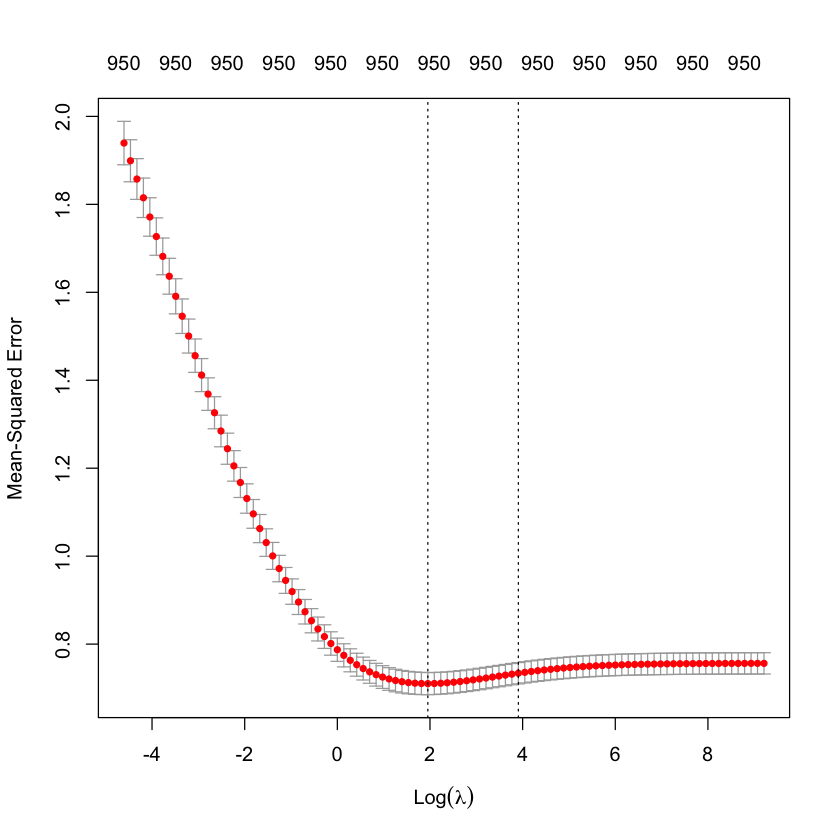

In [31]:
plot(cv_ridge)

This plots the cross-validation curve (red dotted line) along with upper and lower standard deviation curves
along the $\lambda$ sequence (error bars). 

Two special values along the $\lambda$ sequence are indicated by the vertical dotted lines:
 - lambda.min is the value of $\lambda$ that gives minimum mean cross-validated error, while 
 - lambda.1se is the value of $\lambda$ that gives the most regularized model such that the cross-validated error is within one standard error of the minimum.

We can use the following code to get the value of `lambda.min` 

In [32]:
cv_ridge$lambda.min

[1] 7.054802

In [33]:
log(cv_ridge$lambda.min)

[1] 1.953709

and the model coefficients at that value of $\lambda$:

In [34]:
head(coef(cv_ridge, s = "lambda.min"))

6 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept)  2.954717563
educ         0.004829033
black       -0.025465346
hispanic     0.006616148
other       -0.033816794
exp         -0.003777411

In practice, the 1SE rule is sometimes used because some studies found that models chosen by $\lambda_{1SE}$ **tend to perform better on test data** than those chosen by $\lambda_{\min}$ (Hastie et al., *The Elements of Statistical Learning*).

## Lasso

Now let's fit lasso, which can be fit using `glmnet()` with alpha = 1 and seeks to minimize:


$$
\frac{1}{2n}\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}    \right) ^ 2 + \lambda \sum_{j=1}^{p} |\beta_j|
$$

Notice that the intercept is not penalized. 


### No penalty = OLS

In [35]:
lasso_no_pen <- glmnet(
  x = Xsmall,
  y = y,
  alpha = 1, #lasso
  lambda=0
)

In [36]:
lasso_no_pen$beta

2 x 1 sparse Matrix of class "dgCMatrix"
                 s0
educ     0.06977844
mom_educ 0.21337366

In [37]:
summary(lm(y~Xsmall))


Call:
lm(formula = y ~ Xsmall)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8546 -0.4003 -0.0458  0.3573  4.3549 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.827198   0.148795  12.280  < 2e-16 ***
Xsmalleduc     0.069777   0.008997   7.756  1.8e-14 ***
Xsmallmom_educ 0.213382   0.108671   1.964   0.0498 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8392 on 1263 degrees of freedom
Multiple R-squared:  0.0694,	Adjusted R-squared:  0.06793 
F-statistic: 47.09 on 2 and 1263 DF,  p-value: < 2.2e-16


### With Penalty

In [38]:
lasso_pen <- glmnet(
  x = Xsmall,
  y = y,
  alpha = 1, #lasso
  lambda=.02
)

In [39]:
lasso_pen$beta

2 x 1 sparse Matrix of class "dgCMatrix"
                 s0
educ     0.06494371
mom_educ 0.15498206

#### Larger Penalty

In [40]:
lasso_pen_large <- glmnet(
  x = Xsmall,
  y = y,
  alpha = 1, #lasso
  lambda=1e70
)

In [41]:
lasso_pen_large$beta

2 x 1 sparse Matrix of class "dgCMatrix"
         s0
educ      0
mom_educ  .

#### Various Penalties

In [42]:
lasso01 <- glmnet(
  x = Xsmall,
  y = y,
  alpha = 1 #lasso
)

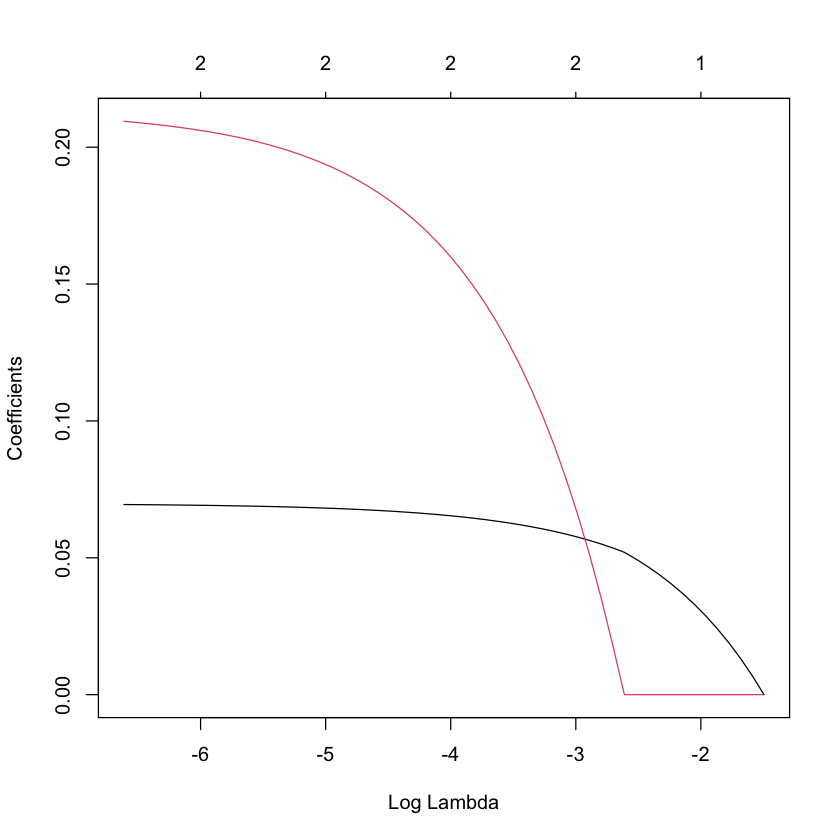

In [43]:
plot(lasso01, xvar = "lambda")

### Penalty selection

In [44]:
cv_lasso <- cv.glmnet(X, y, alpha = 1, lambda = lambda_seq, foldid = folds)

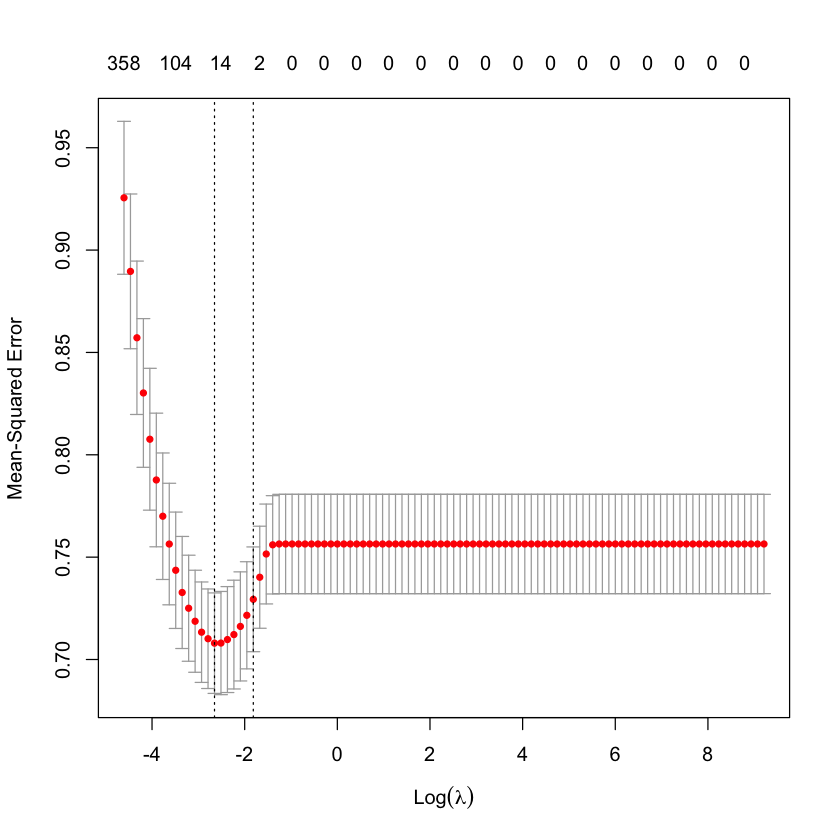

In [45]:
plot(cv_lasso)

In [46]:
cv_lasso$lambda.min

[1] 0.07054802

## Elastic Net 

Now let's fit EN, which can be fit using `glmnet()`  and seeks to minimize:

$$
\frac{1}{2n}\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}    \right) ^ 2 + \lambda\left[(1-\alpha)\frac{1}{2}\|\beta\|_2^2 + \alpha \|\beta\|_1\right],
$$

where 
- If $\alpha=1$ Lasso 
- If $\alpha=0$ Ridge 


- The elastic net simultaneously does automatic variable selection and continuous shrinkage, and it can select groups of correlated variables. 

- It is like a stretchable fishing net that retains ‘all the big fish’.

- Simulation studies and real data examples show that the elastic net often outperforms the lasso in terms of prediction accuracy

- The strict convexity part  of the penalty (ridge) solves the grouping instability problem 

- In **Elastic Net (EN)**, we have **two hyperparameters** to tune:
    1. **$\alpha$**: The mixing parameter between Lasso $(\alpha = 1)$ and Ridge $(\alpha = 0)$.
    2. **$\lambda$**: The penalty strength.
       
    - How to choose $(\lambda,\alpha)$? $\rightarrow$ Bidimensional Crossvalidation


To perform **bidimensional cross-validation** we can follow these steps:

1. **Choose a grid of $\alpha$ values**  from 0 to 1).
2. **For each $\alpha$, perform cross-validation over $\lambda$** using `cv.glmnet()`.
3. **Select the best $\alpha, \lambda$ pair** based on cross-validation error.



In [49]:
# Define alpha grid (e.g., from 0 to 1 in steps of 0.2) #just to be fast, in practice need a finer grid
alpha_grid <- seq(0, 1, by = 0.2)


# Initialize storage for results
cv_results <- data.frame(alpha = numeric(), lambda = numeric(), mse = numeric())

# Perform bidimensional cross-validation
for (alpha_value in alpha_grid) {
  # Perform cross-validation for each alpha
  cv_fit <- cv.glmnet(X, y, alpha = alpha_value, lambda = lambda_seq, foldid = folds) #note we are using the same folds and lambda sequences as before
  #how many specifications are we running?
    
  # Store best lambda and corresponding MSE
  best_lambda <- cv_fit$lambda.min
  best_mse <- min(cv_fit$cvm)  # Mean CV error
  
  # Append results
  cv_results <- rbind(cv_results, data.frame(alpha = alpha_value, lambda = best_lambda, mse = best_mse))
}


In [50]:
cv_results

alpha,lambda,mse
<dbl>,<dbl>,<dbl>
0.0,7.05480231,0.7101801
0.2,0.28480359,0.7073084
0.4,0.18738174,0.7075226
0.6,0.12328467,0.7074953
0.8,0.09326033,0.7076487
1.0,0.07054802,0.7079828


In [51]:
# Find the best alpha-lambda combination
best_model <- cv_results[which.min(cv_results$mse), ]


# Print best alpha and lambda
print(paste("Best alpha:", best_model$alpha))
print(paste("Best lambda:", best_model$lambda))


[1] "Best alpha: 0.2"
[1] "Best lambda: 0.28480358684358"


In [53]:
# Train the final model with the best alpha and lambda
final_model <- glmnet(X, y, alpha = best_model$alpha, lambda = best_model$lambda)

In [54]:
# coef(final_model)

994 x 1 sparse Matrix of class "dgCMatrix"
                                      s0
(Intercept)                 2.709036e+00
educ                        2.649066e-02
black                      -9.018004e-02
hispanic                    .           
other                       .           
exp                        -1.954239e-03
afqt                        2.599852e-02
mom_educ                    .           
dad_educ                    .           
yhea_100_1997               .           
yhea_2000_1997              .           
yhea_2100_1997              .           
yhea_2200_1997              .           
ysaq_284_1997               1.726675e-03
ysaq_285_1997               .           
ysaq_291a_1997              .           
ysaq_292_1997               .           
ysaq_293_1997               .           
ysaq_294_1997               .           
ysaq_294a_1997              .           
ysaq_295_1997               .           
ysaq_296_1997               .           
ysaq_297_1997 

- **Elastic Net performs best when $\alpha$ is optimized** rather than arbitrarily chosen.
- **Allows flexibility between Lasso and Ridge**, automatically adjusting to the dataset.
- **Prevents overfitting or underfitting** by tuning both hyperparameters simultaneously.
